In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# PART A: Recurrent Neural Network & Classification:
## 1. Data Processing
### a) Import the following libraries: 

In [2]:
import sys
import os
import json
import pandas
import numpy
import optparse

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
# from keras.layers.embeddings import Embedding         # Not working
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from keras.optimizers import SGD
from keras import metrics

from keras.utils.data_utils import pad_sequences    # Since my keras is greater version 2.8, this is required for pad_sequences

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

pandas.set_option('display.max_rows', 100)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_colwidth', 500)

from sklearn.model_selection import train_test_split

Mounted at /content/gdrive


In [3]:
dataframe = pandas.read_csv("/content/gdrive/MyDrive/dev-access.csv", engine='python', quotechar='|', header=None)
dataset = dataframe.values # convert to a numpy.ndarray type
dataset.shape

(26773, 2)

In [4]:
dataframe.head()

,0,1
0,"{""timestamp"":1502738402847,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""88.141.113.237"",""referer"":""http://localhost:8002/enter""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""accept-language"":""en-us"",""accept-encoding"":""gzip, deflate"",""connection"":""keep-alive"",""accept"":""*/*"",""referer"":""http://localhost:8002/enter"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest"",""content-type"":""application/json"",""content-length"":""36""},""requestPayl...",0
1,"{""timestamp"":1502738402849,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""88.141.113.237""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""content-length"":""47""},""requestPayload"":{""username"":""pafzah"",""password"":""worldburn432""},""responsePayload"":{""statusCode"":401,""erro...",0
2,"{""timestamp"":1502738402852,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""205.49.83.118""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""content-length"":""44""},""requestPayload"":{""username"":""Panos1"",""password"":""najrijkom""},""responsePayload"":{""statusCode"":401,""error"":""...",0
3,"{""timestamp"":1502738402852,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""205.49.83.118"",""referer"":""http://localhost:8002/enter""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""accept-language"":""en-us"",""accept-encoding"":""gzip, deflate"",""connection"":""keep-alive"",""accept"":""*/*"",""referer"":""http://localhost:8002/enter"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest"",""content-type"":""application/json"",""content-length"":""47""},""requestPaylo...",0
4,"{""timestamp"":1502738402853,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""137.196.95.116""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""content-length"":""41""},""requestPayload"":{""username"":""Michele"",""password"":""mokgu""},""responsePayload"":{""statusCode"":401,""error"":""Un...",0


In [5]:
dataframe[0]

0        {"timestamp":1502738402847,"method":"post","query":{},"path":"/login","statusCode":401,"source":{"remoteAddress":"88.141.113.237","referer":"http://localhost:8002/enter"},"route":"/login","headers":{"host":"localhost:8002","accept-language":"en-us","accept-encoding":"gzip, deflate","connection":"keep-alive","accept":"*/*","referer":"http://localhost:8002/enter","cache-control":"no-cache","x-requested-with":"XMLHttpRequest","content-type":"application/json","content-length":"36"},"requestPayl...
1        {"timestamp":1502738402849,"method":"post","query":{},"path":"/login","statusCode":401,"source":{"remoteAddress":"88.141.113.237"},"route":"/login","headers":{"host":"localhost:8002","connection":"keep-alive","cache-control":"no-cache","accept":"*/*","accept-encoding":"gzip, deflate, br","accept-language":"en-US,en;q=0.8,es;q=0.6","content-type":"application/json","content-length":"47"},"requestPayload":{"username":"pafzah","password":"worldburn432"},"responsePayload":{"statusC

In [6]:
dataframe[dataframe[1] == 1]

,0,1
133,"{""timestamp"":1502738402889,""method"":""get"",""query"":{},""path"":""/phpmyAdmin/"",""statusCode"":404,""source"":{""remoteAddress"":""98.195.246.63""},""route"":""/{p*}"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6""},""requestPayload"":null,""responsePayload"":{""statusCode"":404,""error"":""Not Found"",""message"":""Not Found""}}",1
511,"{""timestamp"":1502738402894,""method"":""get"",""query"":{},""path"":""/phpmyadmin2012/"",""statusCode"":404,""source"":{""remoteAddress"":""98.195.246.63"",""referer"":""http://localhost:8002/enter""},""route"":""/{p*}"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""accept"":""*/*"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest"",""referer"":""http://localhost:8002/enter"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6""},""requestPayload"":null,""responsePayload""...",1
512,"{""timestamp"":1502738402896,""method"":""get"",""query"":{},""path"":""/phpmyadmin2012"",""statusCode"":404,""source"":{""remoteAddress"":""98.195.246.63"",""referer"":""http://localhost:8002/enter""},""route"":""/{p*}"",""headers"":{""host"":""localhost:8002"",""accept-language"":""en-us"",""accept-encoding"":""gzip, deflate"",""connection"":""keep-alive"",""accept"":""*/*"",""referer"":""http://localhost:8002/enter"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest""},""requestPayload"":null,""responsePayload"":{""statusCode"":404,""err...",1
513,"{""timestamp"":1502738402897,""method"":""get"",""query"":{},""path"":""/pma2013"",""statusCode"":404,""source"":{""remoteAddress"":""98.195.246.63"",""referer"":""http://localhost:8002/enter""},""route"":""/{p*}"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""accept"":""*/*"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest"",""referer"":""http://localhost:8002/enter"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6""},""requestPayload"":null,""responsePayload"":{""statu...",1
514,"{""timestamp"":1502738402897,""method"":""get"",""query"":{},""path"":""/pma2018"",""statusCode"":404,""source"":{""remoteAddress"":""98.195.246.63""},""route"":""/{p*}"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6""},""requestPayload"":null,""responsePayload"":{""statusCode"":404,""error"":""Not Found"",""message"":""Not Found""}}",1
...,...,...
26768,"{""timestamp"":1502738797528,""method"":""post"",""query"":{},""path"":""/checkout"",""statusCode"":400,""source"":{""remoteAddress"":""227.176.162.199"",""referer"":""http://localhost:8002/enter""},""route"":""/checkout"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""accept"":""*/*"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest"",""referer"":""http://localhost:8002/enter"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""conte...",1
26769,"{""timestamp"":1502738798712,""method"":""post"",""query"":{},""path"":""/checkout"",""statusCode"":400,""source"":{""remoteAddress"":""182.239.131.78""},""route"":""/checkout"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""content-length"":""126""},""requestPayload"":{""creditCard"":""<!DOCTYPE foo [<!ELEMENT root ANY ><!ENTITY unixfile SYSTEM \""file:...",1
26770,"{""timestamp"":1502738800390,""method"":""post"",""query"":{},""path"":""/checkou

In [7]:
dataframe[1].value_counts()

0    13413
1    13360
Name: 1, dtype: int64

In [8]:
X = dataset[:,0]    # Store all rows and the 0th index as the feature data
Y = dataset[:,1]    # Store all rows and index 1 as the target variable

### In the next step, we will clean up the predictors. This includes removing features that are not valuable, such as timestamp and source. 

In [9]:
for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

X

array(['{"method":"post","query":{},"path":"/login","statusCode":401,"requestPayload":{"username":"Carl2","password":"bo"}}',
       '{"method":"post","query":{},"path":"/login","statusCode":401,"requestPayload":{"username":"pafzah","password":"worldburn432"}}',
       '{"method":"post","query":{},"path":"/login","statusCode":401,"requestPayload":{"username":"Panos1","password":"najrijkom"}}',
       ...,
       '{"method":"post","query":{},"path":"/checkout","statusCode":400,"requestPayload":{"creditCard":"<script src=\\"http://attacker/malicious\\u2011script.js\\"></script>"}}',
       '{"method":"post","query":{},"path":"/checkout","statusCode":400,"requestPayload":{"creditCard":"<meta http-equiv=\\"refresh\\">"}}',
       '{"method":"post","query":{},"path":"/checkout","statusCode":400,"requestPayload":{"creditCard":"<meta http-equiv=\\"refresh\\">"}}'],
      dtype=object)

In [10]:
Y = numpy.asarray(Y).astype(numpy.int32)      # since it is of type object, converting to float32 to avoid the error "ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int). site:stackoverflow.com"

### We next will tokenize our data, which just means vectorizing our text. Given the data we will tokenize every character (thus char_level = True)

In [11]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

### Need to pad our data as each observation has a different length

In [12]:
max_log_length = 1024
X_processed = pad_sequences(X, maxlen=max_log_length)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, train_size=0.75, test_size=0.25, random_state=42)

print("Train data shape: " + str(X_train.shape))
print("Test data shape: " + str(X_test.shape))

Train data shape: (20079, 1024)
Test data shape: (6694, 1024)


## 2. Model 1 - RNN: The first model will be a pretty minimal RNN with only an embedding layer, simple RNN and Dense layer. The next model we will add a few more layers. 

In [14]:
model = Sequential()   # creating an instance of a Sequential model
model.add(Embedding(input_dim = num_words, output_dim = 32, input_length = max_log_length))     # add an Embedding layer
model.add(SimpleRNN(units = 32, activation = 'relu'))   # Add a SimpleRNN layer
model.add(Dense(units = 1, activation = 'relu'))    # add a Dense layer (this will be our output)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])     # Compile model using the .compile() method

### Print the model summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 32)          2016      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


### Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [16]:
model.fit(X_train, y_train, validation_split = 0.25, epochs = 3, batch_size = 128)

Epoch 1/3
118/118 [==============================] - 37s 304ms/step - loss: 0.7286 - accuracy: 0.6070 - val_loss: 0.6891 - val_accuracy: 0.6076
Epoch 2/3
118/118 [==============================] - 35s 300ms/step - loss: 0.6009 - accuracy: 0.6339 - val_loss: 0.5834 - val_accuracy: 0.6464
Epoch 3/3
118/118 [==============================] - 35s 300ms/step - loss: 0.5776 - accuracy: 0.6473 - val_loss: 0.5681 - val_accuracy: 0.6506


### Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [17]:
model.evaluate(X_test, y_test, batch_size = 128)

53/53 [==============================] - 2s 44ms/step - loss: 0.5641 - accuracy: 0.6651


[0.5641258955001831, 0.6650732159614563]

## 3) Model 2 - LSTM + Dropout Layers:
Now we will add a few new layers to our RNN and incorporate the more powerful LSTM. You will be creating a new model here, so make sure to call it something different than the model from Part 2.

In [18]:
model_1 = Sequential()
model_1.add(Embedding(input_dim = num_words, output_dim = 32, input_length = max_log_length))   # Embedding Layer (use same params as before)
model_1.add(LSTM(units = 64, recurrent_dropout = 0.5))  # LSTM Layer (units = 64, recurrent_dropout = 0.5)
model_1.add(Dropout(0.5))   # Dropout Layer - use a value of 0.5 (rate)
model_1.add(Dense(units = 1, activation = 'relu'))  # Dense Layer - (use same params as before)
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Print the model summary

In [19]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


### Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [20]:
model_1.fit(X_train, y_train, validation_split = 0.25, epochs = 3, batch_size = 128)

Epoch 1/3
118/118 [==============================] - 92s 760ms/step - loss: 0.8028 - accuracy: 0.5535 - val_loss: 0.6776 - val_accuracy: 0.6265
Epoch 2/3
118/118 [==============================] - 89s 759ms/step - loss: 0.6752 - accuracy: 0.7583 - val_loss: 0.9019 - val_accuracy: 0.7456
Epoch 3/3
118/118 [==============================] - 89s 755ms/step - loss: 0.6924 - accuracy: 0.6005 - val_loss: 0.4253 - val_accuracy: 0.8773


### Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [21]:
model_1.evaluate(X_test, y_test, batch_size = 128)

53/53 [==============================] - 10s 179ms/step - loss: 0.4300 - accuracy: 0.8703


[0.4300204813480377, 0.8703316450119019]

## 4) Recurrent Neural Net Model 3: Build Your Own

In [22]:
from keras.layers import Bidirectional

model_2 = Sequential()
model_2.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length))
model_2.add(Bidirectional(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5)))
model_2.add(Dense(units=16, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(units=1, activation='sigmoid'))

model_2.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision()])


### Print the model summary

In [23]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 53,761
Trainable params: 53,761
Non-trainable params: 0
__________________________________________________

### Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [24]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_2.fit(X_train, y_train, validation_split=0.25, epochs=10, callbacks=[callback], batch_size = 128)

Epoch 1/10
118/118 [==============================] - 115s 928ms/step - loss: 0.6933 - accuracy: 0.4973 - precision: 0.4991 - val_loss: 0.6929 - val_accuracy: 0.5713 - val_precision: 0.9394
Epoch 2/10
118/118 [==============================] - 108s 919ms/step - loss: 0.6930 - accuracy: 0.5104 - precision: 0.5116 - val_loss: 0.6928 - val_accuracy: 0.3892 - val_precision: 0.3961
Epoch 3/10
118/118 [==============================] - 108s 918ms/step - loss: 0.6929 - accuracy: 0.5135 - precision: 0.5146 - val_loss: 0.6928 - val_accuracy: 0.5038 - val_precision: 0.5038
Epoch 4/10
118/118 [==============================] - 110s 933ms/step - loss: 0.6928 - accuracy: 0.5083 - precision: 0.5073 - val_loss: 0.6928 - val_accuracy: 0.5038 - val_precision: 0.5038
Epoch 5/10
118/118 [==============================] - 109s 920ms/step - loss: 0.6928 - accuracy: 0.5080 - precision: 0.5063 - val_loss: 0.6927 - val_accuracy: 0.5038 - val_precision: 0.5038
Epoch 6/10
118/118 [==============================

In [25]:
model_2.fit(X_train, y_train, validation_split = 0.25, epochs = 3, batch_size = 128)

Epoch 1/3
118/118 [==============================] - 108s 918ms/step - loss: 0.6926 - accuracy: 0.5061 - precision: 0.5055 - val_loss: 0.6923 - val_accuracy: 0.5038 - val_precision: 0.5038
Epoch 2/3
118/118 [==============================] - 108s 917ms/step - loss: 0.6924 - accuracy: 0.5281 - precision: 0.5262 - val_loss: 0.6923 - val_accuracy: 0.5038 - val_precision: 0.5038
Epoch 3/3
118/118 [==============================] - 109s 921ms/step - loss: 0.6923 - accuracy: 0.5273 - precision: 0.5285 - val_loss: 0.6922 - val_accuracy: 0.5038 - val_precision: 0.5038


### Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [26]:
model_2.evaluate(X_test, y_test, batch_size = 128)

53/53 [==============================] - 10s 182ms/step - loss: 0.6922 - accuracy: 0.4886 - precision: 0.4886


[0.6921905279159546, 0.488646537065506, 0.488646537065506]

## Conceptual Questions: 

<b>5) Explain the difference between the relu activation function and the sigmoid activation function.</b><br>
- Relu:
    - Simple and efficient activation function
    - Nonlinear function that returns 0 for negative inputs and the input value for positive inputs
    - Used in hidden layers of deep neural networks
    - Helps avoid vanishing gradients and speed up training
    - Does not have a defined upper limit and can cause exploding gradients
- Sigmoid:
    - S-shaped curve that returns values between 0 and 1
    - Used in output layers for binary classification problems
    - Interpretation as probability scores
    - Tends to slow down learning in deep networks
    - Suffers from vanishing gradients for large input values.

<b>6) Describe what one epoch actually is (epoch was a parameter used in the .fit() method).</b><br>
In machine learning, an epoch refers to one complete iteration of the entire dataset during the training process. During one epoch, the algorithm takes the entire dataset as input, processes it through the neural network, and updates the weights of the network based on the loss function. The number of epochs is a hyperparameter that determines how many times the algorithm should run through the entire dataset.

<b>7) Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.</b><br>
Dropout is a regularization technique used to prevent overfitting in neural networks during training. Dropout works by randomly setting a fraction of the input units to zero at each update during training time, which helps to prevent complex co-adaptations on training data and reduces overfitting.
Specifically, dropout randomly selects a fraction of the input units and sets their values to zero at each training iteration. The fraction of the input units that are zeroed out is determined by the dropout rate, which is a hyperparameter that is typically set between 0.2 and 0.5.
During training, dropout helps to prevent overfitting by forcing the model to learn more robust features. By randomly dropping out units, the network becomes less sensitive to the specific weights of any one neuron, which in turn makes the network more resilient to noise and more able to generalize to new data.
During testing, the dropout is turned off, and the full network is used to make predictions on new data. However, because the model was trained with dropout, the weights of the network have been scaled down during training, and to make up for this, the weights are multiplied by the dropout rate during testing. This ensures that the expected sum of the weights remains the same, and the model can still make accurate predictions on new data.

<b>8) Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?</b><br>
RNNs are better suited for sequential data modeling, where the input data has a temporal or sequential dependency. In this homework assignment, we are dealing with log data that is a time series data, where the past log messages are dependent on the current log message.
RNNs are designed to handle such time series data as they have the ability to maintain a memory state of previous inputs through their hidden states. This makes RNNs ideal for predicting the next value or sequence in a time series data. On the other hand, CNNs are better suited for image processing and computer vision tasks, where spatial features are more important.
CNNs excel at finding patterns in the spatial structure of data. For example, they can be used to identify features in an image such as edges, corners, and blobs. Thus, CNNs are better suited for problems such as image classification, object detection, and segmentation where local patterns in the data are important.

<b>9) Explain what RNN problem is solved using LSTM and briefly describe how.</b><br>
LSTMs are a type of RNN designed to address the vanishing gradient problem by allowing information to be retained or forgotten over time.
They achieve this by having a "memory cell" that stores information over time, a set of "gates" that regulate the flow of information into and out of the cell, and an "output" that produces the final prediction.
The gates are composed of sigmoid activation functions, which output values between 0 and 1 that determine how much information should be let through.
The "input gate" determines how much new information should be let into the cell, the "forget gate" determines how much old information should be forgotten, and the "output gate" determines how much information should be outputted.
By selectively allowing or blocking the flow of information over time, LSTMs are able to handle long-term dependencies in sequential data and avoid the vanishing gradient problem

# PART B: Time Series with LSTMs

## 1. Import, clean and plot the input data

In [27]:
import sys
import os
import json
import pandas as pd
import numpy as np
import optparse

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Bidirectional
# from keras.layers.embeddings import Embedding         # Not working
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from keras.optimizers import SGD
from keras import metrics

from keras.utils.data_utils import pad_sequences    # Since my keras is greater version 2.8, this is required for pad_sequences

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

pandas.set_option('display.max_rows', 100)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_colwidth', 500)

import sys    
path_to_module = '/content/gdrive/MyDrive'
sys.path.append(path_to_module)

import matplotlib.pyplot as plt

import helper
# from sklearn.model_selection import train_test_split

Mounted at /content/gdrive


In [28]:
data = pd.read_csv('/content/gdrive/MyDrive/DAYTON_hourly.csv')
data.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [29]:
df = data.copy()
df.Datetime = pd.to_datetime(df.Datetime)
df = df.sort_values(by='Datetime')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121275 entries, 2183 to 116163
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datetime   121275 non-null  datetime64[ns]
 1   DAYTON_MW  121275 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 MB


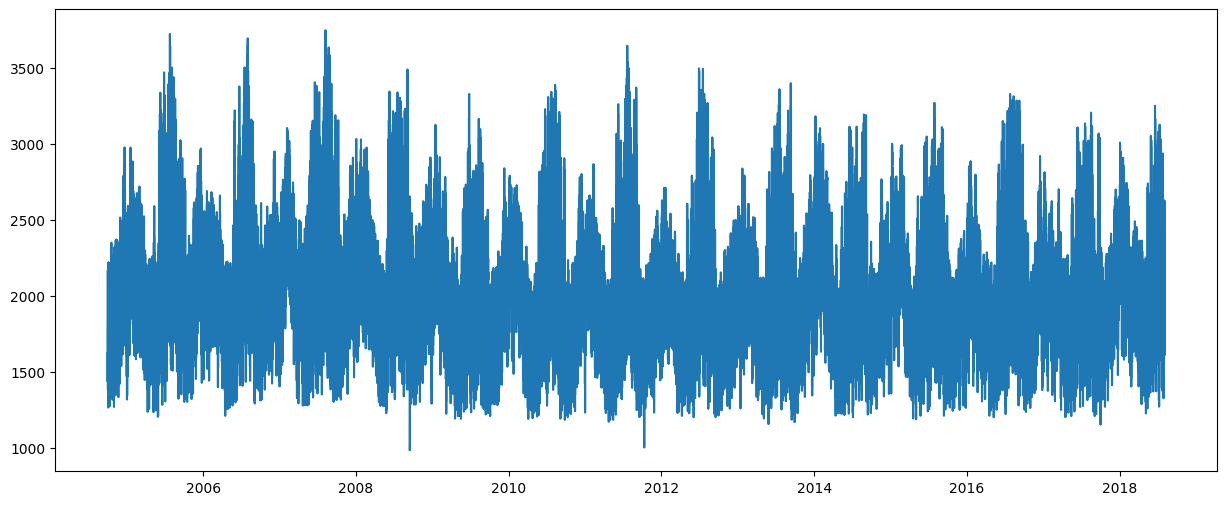

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(df['Datetime'], df['DAYTON_MW'])

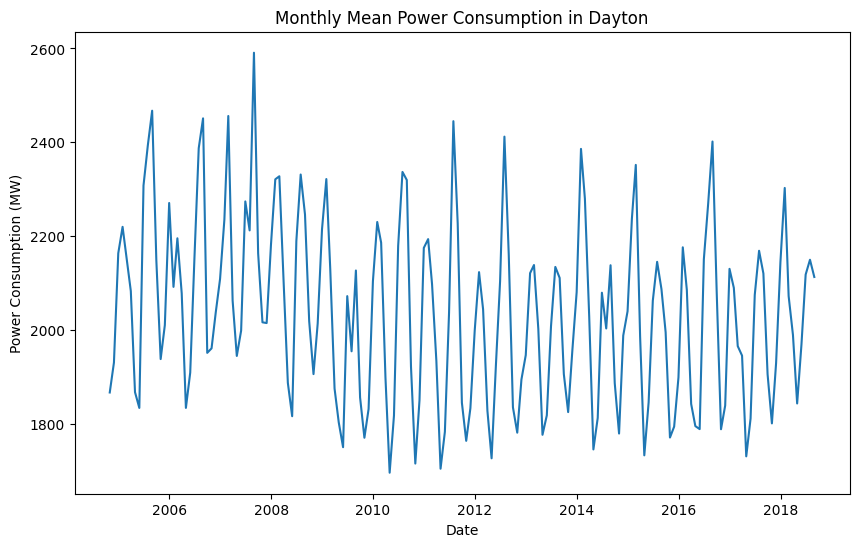

In [32]:
# df1 = df.copy()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
monthly_df = df['DAYTON_MW'].resample('M').mean()

# Create the plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_df.index, monthly_df.values)

# Format the plot
ax.set_title('Monthly Mean Power Consumption in Dayton')
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption (MW)')
plt.show()

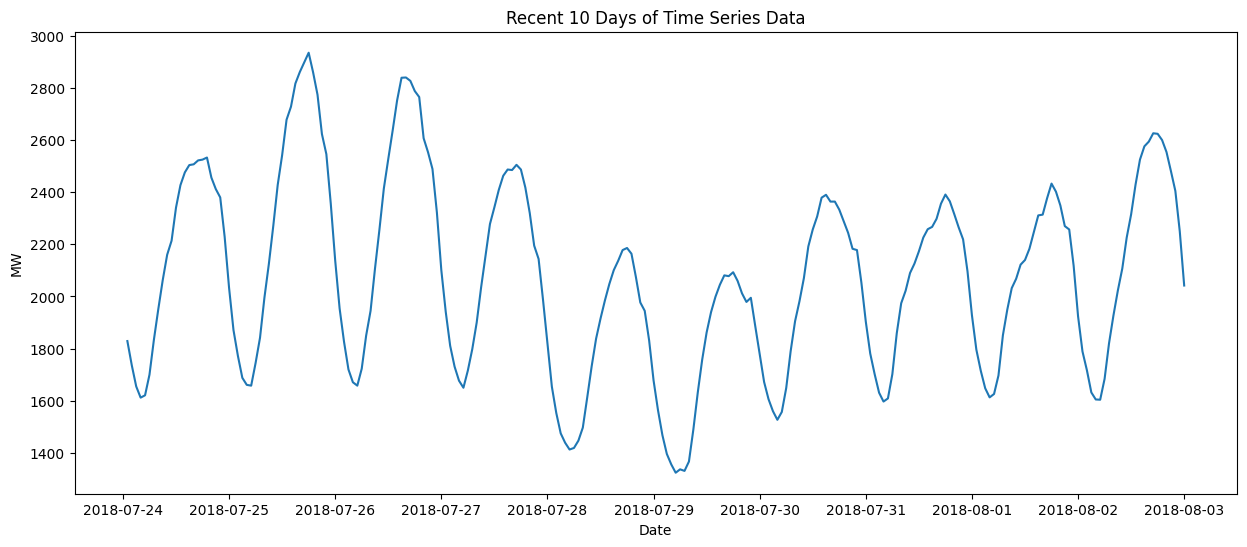

In [33]:
# Get the last 10 days of data
last_10_days = df.tail(240)

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(last_10_days.index, last_10_days['DAYTON_MW'])
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Recent 10 Days of Time Series Data')
plt.show()

### Train test split (use provided helper function helper.py Download helper.py, as we can’t use sklearn’s for time series data)

In [34]:
lag = 3
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = helper.create_data_for_NN(df, df.columns[-1], lag, test_ratio)

### Fit a single layer LSTM with lag = 3 hours

In [35]:
lag = 3

model_4 = Sequential()
model_4.add(LSTM(units=32, input_shape=(lag, 1)))
model_4.add(Dense(units=1))

model_4.compile(optimizer='adam', loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])
model_4.fit(X_train, Y_train, validation_split=0.25, epochs=10, batch_size=32)

Epoch 1/10
2416/2416 [==============================] - 10s 4ms/step - loss: 4357394.5000 - rmse: 2087.4373 - val_loss: 4044246.5000 - val_rmse: 2011.0312
Epoch 2/10
2416/2416 [==============================] - 8s 3ms/step - loss: 4298018.0000 - rmse: 2073.1663 - val_loss: 3987002.0000 - val_rmse: 1996.7478
Epoch 3/10
2416/2416 [==============================] - 8s 3ms/step - loss: 4239103.5000 - rmse: 2058.9084 - val_loss: 3930168.2500 - val_rmse: 1982.4652
Epoch 4/10
2416/2416 [==============================] - 8s 3ms/step - loss: 4180619.5000 - rmse: 2044.6564 - val_loss: 3873778.7500 - val_rmse: 1968.1918
Epoch 5/10
2416/2416 [==============================] - 8s 3ms/step - loss: 4122548.0000 - rmse: 2030.4059 - val_loss: 3817801.0000 - val_rmse: 1953.9194
Epoch 6/10
2416/2416 [==============================] - 8s 3ms/step - loss: 4064901.2500 - rmse: 2016.1600 - val_loss: 3762245.5000 - val_rmse: 1939.6509
Epoch 7/10
2416/2416 [==============================] - 8s 3ms/step - loss:

In [36]:
y_pred_lstm3 = model_4.predict(X_test)
rmse_lstm3 = np.sqrt(np.mean((Y_test - y_pred_lstm3) ** 2))

print(rmse_lstm3)

569/569 [==============================] - 1s 1ms/step
1922.5405354231714


### Fit a single layer LSTM with lag = 24 hours

In [37]:
lag = 24
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = helper.create_data_for_NN(df, df.columns[-1], lag, test_ratio)

model_5 = Sequential()
model_5.add(LSTM(units=32, input_shape=(lag, 1)))
model_5.add(Dense(units=1))

model_5.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

model_5.fit(X_train, Y_train, validation_split=0.25, epochs=10, batch_size = 128)

Epoch 1/10
604/604 [==============================] - 10s 13ms/step - loss: 4376143.0000 - accuracy: 0.0000e+00 - root_mean_squared_error: 2091.9233 - val_loss: 4082117.7500 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 2020.4252
Epoch 2/10
604/604 [==============================] - 8s 13ms/step - loss: 4354840.5000 - accuracy: 0.0000e+00 - root_mean_squared_error: 2086.8254 - val_loss: 4059436.5000 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 2014.8043
Epoch 3/10
604/604 [==============================] - 7s 12ms/step - loss: 4331544.0000 - accuracy: 0.0000e+00 - root_mean_squared_error: 2081.2361 - val_loss: 4038080.2500 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 2009.4976
Epoch 4/10
604/604 [==============================] - 8s 13ms/step - loss: 4309909.5000 - accuracy: 0.0000e+00 - root_mean_squared_error: 2076.0322 - val_loss: 4017412.0000 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 2004.3483
Epoch 5/10
604/604 [===============

In [38]:
y_pred_lstm24 = model_5.predict(X_test)
rmse_lstm24 = np.sqrt(np.mean((Y_test - y_pred_lstm24) ** 2))
print(rmse_lstm24)

569/569 [==============================] - 2s 3ms/step
2013.7753853253478


### Fit a bidirectional LSTM with lag = 24 hours

In [39]:
lag = 24

model_6 = Sequential()
model_6.add(Bidirectional(LSTM(50, input_shape=(lag, 1))))
model_6.add(Dense(1))
model_6.compile(optimizer="adam", loss="mse")
model_6.fit(X_train, Y_train, validation_split=0.25, epochs=10, batch_size=32)

Epoch 1/10
2416/2416 [==============================] - 32s 12ms/step - loss: 4241689.0000 - val_loss: 3827702.5000
Epoch 2/10
2416/2416 [==============================] - 27s 11ms/step - loss: 3969283.5000 - val_loss: 3570160.7500
Epoch 3/10
2416/2416 [==============================] - 27s 11ms/step - loss: 3707923.7500 - val_loss: 3322408.2500
Epoch 4/10
2416/2416 [==============================] - 27s 11ms/step - loss: 3456197.2500 - val_loss: 3084276.0000
Epoch 5/10
2416/2416 [==============================] - 27s 11ms/step - loss: 3213957.7500 - val_loss: 2855461.0000
Epoch 6/10
2416/2416 [==============================] - 27s 11ms/step - loss: 2981120.2500 - val_loss: 2636095.7500
Epoch 7/10
2416/2416 [==============================] - 27s 11ms/step - loss: 2757681.0000 - val_loss: 2426129.7500
Epoch 8/10
2416/2416 [==============================] - 27s 11ms/step - loss: 2543507.7500 - val_loss: 2225394.7500
Epoch 9/10
2416/2416 [==============================] - 27s 11ms/step - 

In [40]:
y_pred_bidir = model_6.predict(X_test)
rmse_bidir = np.sqrt(np.mean((Y_test - y_pred_bidir) ** 2))
print(rmse_bidir)

569/569 [==============================] - 3s 4ms/step
1401.2976784276234


### Plot results on test set and compare performance using RMSE

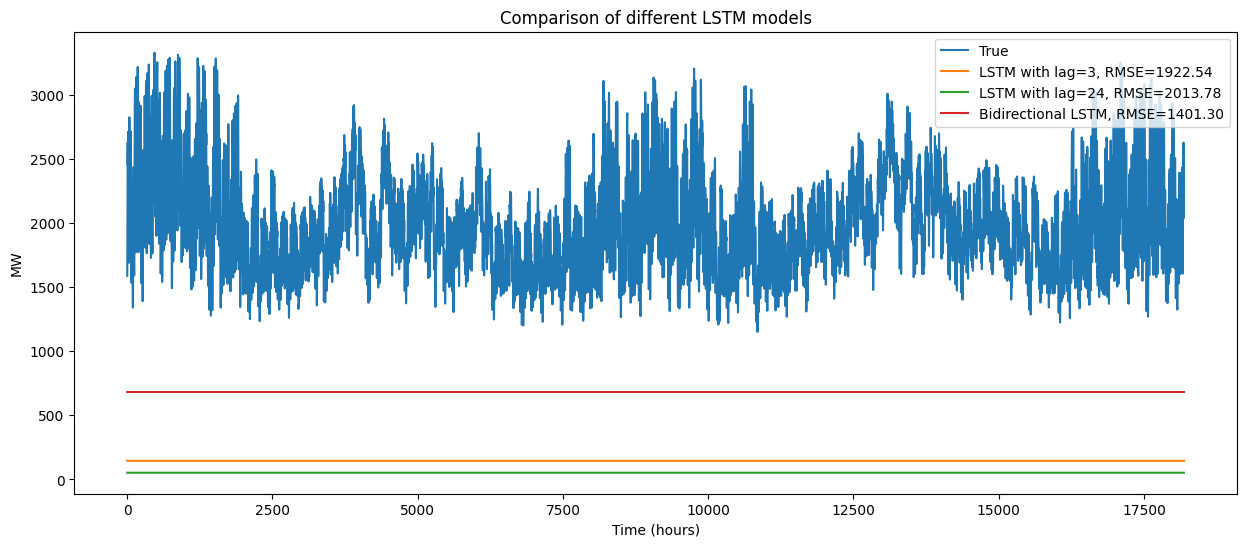

In [41]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label="True")
plt.plot(y_pred_lstm3, label="LSTM with lag=3, RMSE={:.2f}".format(rmse_lstm3))
plt.plot(y_pred_lstm24, label="LSTM with lag=24, RMSE={:.2f}".format(rmse_lstm24))
plt.plot(y_pred_bidir, label="Bidirectional LSTM, RMSE={:.2f}".format(rmse_bidir))
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("MW")
plt.title("Comparison of different LSTM models")
plt.show()

Bidirectional is the worst performing mode, followed by the model with lag 3 and then the lag 24.